# 🌍 World Happiness Report

## Exploratory Data Analysis

### Data Source & Analysis Objective

#### Data Source
본 분석은 World Happiness Report 공개 데이터를 기반으로 합니다.<br />
데이터에는 국가별 행복 점수(Happiness Score)와 행복 순위(Happiness Rank)가 포함되어 있으며,<br />
CSV 형식으로 제공되어 국가 단위 분석이 가능합니다.

본 노트북에서는 Kaggle에 공개된 다음의 데이터셋을 사용합니다.

---

##### Data
* **2015 ~ 2019**: https://www.kaggle.com/datasets/unsdsn/world-happiness
* **2020 ~ 2024**: https://www.kaggle.com/datasets/samithsachidanandan/world-happiness-report-2020-2024

---

#### Analysis Objective
본 분석의 목적은 다음과 같습니다.
- 데이터의 기본 구조 및 품질 확인
- 결측치와 이상치 분포 파악
- 전 세계 국가별 행복 점수와 순위를 지도 시각화로 비교

### Environment & Libraries
본 노트북은 개인 로컬 환경의 Jupyter Notebook에서 실행되었으며,
탐색적 데이터 분석(EDA), 통계적 시각화,
그리고 전 세계 지리적 데이터 시각화를 위해
표준 Python 라이브러리를 사용합니다.

사용된 라이브러리는 추후 Kaggle 노트북 환경에서도
호환 가능하도록 구성되었습니다.

In [1]:
# ==================================================
# Core libraries
# Numerical computation & tabular data handling
# 수치 연산 및 테이블 형태 데이터 처리를 위한 라이브러리
# ==================================================
import numpy as np
import pandas as pd
from scipy import stats

# ==================================================
# Visualization libraries
# Statistical plots & EDA charts
# 통계 그래프 및 EDA 시각화를 위한 라이브러리
# ==================================================
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from shapely.geometry import box

# ==================================================
# Geospatial libraries
# World map visualization & country matching
# 세계 지도 시각화 및 국가명/국가 코드 매핑을 위한 라이브러리
# ==================================================
import geopandas as gpd
import country_converter as coco

# ==================================================
# Utilities
# Warning control & notebook settings
# 경고 메시지 제어 및 노트북 실행 환경 설정
# ==================================================
import warnings

warnings.filterwarnings("ignore")

#### Visualization Settings

Matplotlib에서 한글이 정상적으로 표시되도록 <br />
실행 환경에 따라 사용 가능한 한글 폰트를 자동으로 설정합니다. <br />
또한 음수 기호(−)가 깨지는 문제를 방지하기 위해 관련 설정을 함께 적용합니다.

In [2]:
import matplotlib.font_manager as fm    # Matplotlib에서 폰트 설정을 위해 font manager 호출

# 후보 폰트 목록 (환경별 대응)
font_candidates = [
    "NanumGothic",      # Linux / Kaggle
    "AppleGothic",     # macOS
    "Malgun Gothic"    # Windows
]

# 시스템에서 사용 가능한 폰트 목록을 dict 형태로 저장
available_fonts = {f.name: f.fname for f in fm.fontManager.ttflist}

# 후보 폰트 중 사용 가능한 폰트를 찾아 적용한 뒤 반복문 종료
for font in font_candidates:
    if font in available_fonts:
        plt.rcParams["font.family"] = font
        break

# 마이너스 기호(−)가 깨지는 현상 방지
plt.rcParams["axes.unicode_minus"] = False

### Data Loading & Overview

#### Happiness Dataset

In [3]:
# load to dataset
happiness_df = pd.read_csv('./data/happiness_2015_2024.csv')

##### Missing Values Analysis

In [4]:
# DataFrame 크기
happiness_df.shape

(1510, 10)

In [5]:
# Dataframe 5행 출력
happiness_df.head()

,year,country,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
0,2015,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978
1,2015,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145
2,2015,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357
3,2015,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503
4,2015,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957


In [6]:
# DataFrame 값 확인
happiness_df.describe()

,year,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
count,1510.000000,1510.000000,1510.000000,1507.000000,1507.000000,1506.000000,1507.000000,1507.000000,1506.000000
mean,2019.386093,76.144371,5.449274,1.052821,1.053570,0.578193,0.466545,0.191633,0.134292
std,2.857553,43.850630,1.122885,0.462911,0.332261,0.239482,0.164760,0.111113,0.114028
min,2015.000000,1.000000,1.721000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017.000000,38.000000,4.603500,0.740685,0.841210,0.401490,0.367075,0.112000,0.058098
50%,2019.000000,76.000000,5.472000,1.070000,1.093000,0.602185,0.481810,0.177000,0.100000
75%,2022.000000,114.000000,6.269000,1.373500,1.318130,0.760000,0.585300,0.248041,0.171000
max,2024.000000,158.000000,7.842000,2.209000,1.644000,1.141000,0.863000,0.838075,0.587000


In [7]:
# 연도별 국가 수
happiness_df.groupby("year")["country"].nunique().reset_index(name="n_countries").sort_values("year")

,year,n_countries
0,2015,158
1,2016,157
2,2017,155
3,2018,156
4,2019,156
5,2020,153
6,2021,149
7,2022,146
8,2023,137
9,2024,143


In [8]:
# 국가 중복 확인
happiness_df.groupby(["year", "country"]).size().reset_index(name="cnt").query("cnt > 1")

,year,country,cnt


In [9]:
# 2015년 행복 지수 추출
happiness_2015_df = happiness_df.loc[happiness_df['year'] == 2015].copy()

##### Missing Values Analysis

In [10]:
# Dataset structure overview
happiness_2015_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     158 non-null    int64  
 1   country                  158 non-null    str    
 2   rank                     158 non-null    int64  
 3   score                    158 non-null    float64
 4   gdp_per_capita           158 non-null    float64
 5   social_support           158 non-null    float64
 6   healthy_life_expectancy  158 non-null    float64
 7   freedom                  158 non-null    float64
 8   generosity               158 non-null    float64
 9   corruption               158 non-null    float64
dtypes: float64(7), int64(2), str(1)
memory usage: 12.5 KB


In [11]:
# Statistical summary
happiness_2015_df.describe()

,year,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
count,158.0,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,2015.0,79.493671,5.375734,0.846137,0.991046,0.630259,0.428615,0.237296,0.143422
std,0.0,45.754363,1.145010,0.403121,0.272369,0.247078,0.150693,0.126685,0.120034
min,2015.0,1.000000,2.839000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.0,40.250000,4.526000,0.545808,0.856823,0.439185,0.328330,0.150553,0.061675
50%,2015.0,79.500000,5.232500,0.910245,1.029510,0.696705,0.435515,0.216130,0.107220
75%,2015.0,118.750000,6.243750,1.158448,1.214405,0.811013,0.549092,0.309883,0.180255
max,2015.0,158.000000,7.587000,1.690420,1.402230,1.025250,0.669730,0.795880,0.551910


In [12]:
# Statistical summary dtype string
happiness_2015_df.describe(include='str')

,country
count,158
unique,158
top,Switzerland
freq,1


In [13]:
# Missing values check
happiness_2015_df.isna().sum()

year                       0
country                    0
rank                       0
score                      0
gdp_per_capita             0
social_support             0
healthy_life_expectancy    0
freedom                    0
generosity                 0
corruption                 0
dtype: int64

##### Detailed Outlier Analysis

In [14]:
# happiness_2015_df number columns
numeric_cols = happiness_2015_df.select_dtypes(include='number').columns

# rank와 score는 분석 데이터가 아니여서 제거
numeric_cols = [col for col in numeric_cols if col not in ['year', 'rank']]

numeric_cols

['score',
 'gdp_per_capita',
 'social_support',
 'healthy_life_expectancy',
 'freedom',
 'generosity',
 'corruption']

In [15]:
# numeric_cols의 길이를 n_plot에 저장
n_plot = len(numeric_cols)

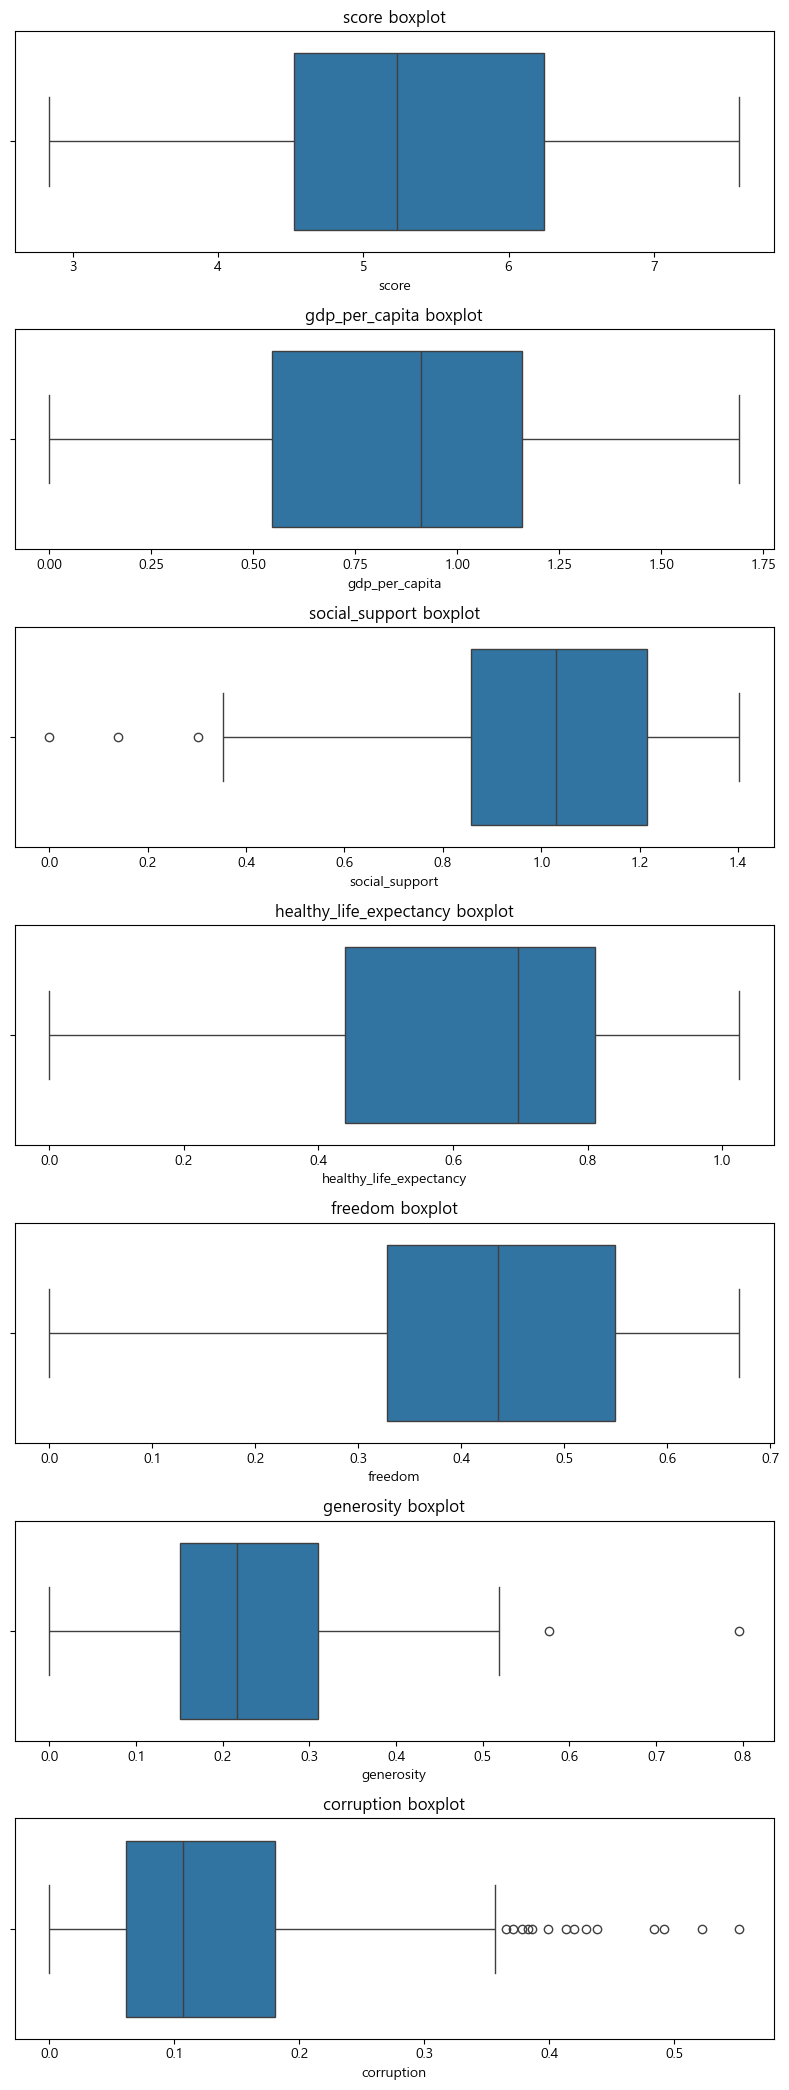

In [16]:
# 팔레트 설정
fig, axes = plt.subplots(
    nrows=n_plot,               # 행을 n_plot만큼 설정
    ncols=1,                    # 열은 1개로 설정
    figsize=(8, 3 * n_plot),    # 사이즈를 좌우는 8, 상하는 n_plot의 갯수에 3을 곱한 만큼
)

# 1 개 일 때도 대응
if n_plot == 1:
    axes = [axes]

# 그래프 출력
for ax, col in zip(axes, numeric_cols):
    sns.boxplot(
        x=happiness_2015_df[col],
        ax=ax,
    )
    ax.set_title(f'{col} boxplot')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()

##### Missing Values & Outliers Summary

수치형 변수 전반에 대해 boxplot을 통해 분포를 확인한 결과,<br />
일부 변수에서 극단값(outliers)이 관찰되었다.<br /><br />
**Standard Error, Trust (Government Corruption),<br />
Generosity 등의 변수에서는 상위 방향으로 치우친 값이 일부 존재**하며,<br />
이는 변수 특성상 **국가 간 편차가 크게 나타날 수 있는 지표로 해석**된다.<br /><br />
**본 분석 단계에서는 이러한 이상치를 즉시 제거하지 않고,<br />
각 변수 간 상관관계(correlation) 및<br />
Happiness Score에 미치는 영향도를 추가로 확인한 후,<br />
분석 목적에 따라 처리 여부를 결정할 예정**이다.

#### Geospatial Dataset

In [17]:
# load for dataset
world_df = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

##### Missing Values Analysis

In [18]:
# Dataset structure overview
world_df.info(verbose=True, show_counts=True, max_cols=None)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 169 columns):
 #    Column      Non-Null Count  Dtype   
---   ------      --------------  -----   
 0    featurecla  177 non-null    str     
 1    scalerank   177 non-null    int32   
 2    LABELRANK   177 non-null    int32   
 3    SOVEREIGNT  177 non-null    str     
 4    SOV_A3      177 non-null    str     
 5    ADM0_DIF    177 non-null    int32   
 6    LEVEL       177 non-null    int32   
 7    TYPE        177 non-null    str     
 8    TLC         176 non-null    str     
 9    ADMIN       177 non-null    str     
 10   ADM0_A3     177 non-null    str     
 11   GEOU_DIF    177 non-null    int32   
 12   GEOUNIT     177 non-null    str     
 13   GU_A3       177 non-null    str     
 14   SU_DIF      177 non-null    int32   
 15   SUBUNIT     177 non-null    str     
 16   SU_A3       177 non-null    str     
 17   BRK_DIFF    177 non-null    int32   
 18   NAME        177 non-

In [19]:
# Statistical summary dtype string
world_df.describe(include='str')

,featurecla,SOVEREIGNT,SOV_A3,TYPE,TLC,ADMIN,ADM0_A3,GEOUNIT,GU_A3,SUBUNIT,...,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA
count,177,177,177,177,176,177,177,177,177,177,...,3,4,5,4,3,3,4,3,6,3
unique,1,171,171,6,1,177,177,177,177,177,...,1,2,2,2,1,2,2,2,3,1
top,Admin-0 country,France,FR1,Sovereign country,1,Fiji,FJI,Fiji,FJI,Fiji,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized
freq,177,3,3,156,176,1,1,1,1,1,...,3,2,4,3,3,2,3,2,3,3


##### Missing valuse Summary

본 섹션에서는 세계 지도 시각화를 위해 사용될 지리 데이터셋의
구조와 주요 컬럼을 확인한다.
해당 데이터는 분석 대상이 아닌 참조용 메타데이터로 활용된다

### Correlation Analysis (Based on Happiness Score)

본 데이터셋에서 **Happiness Rank는 Happiness Score를 기준으로 산출된 순위형 지표이므로 상관관계 분석에서는 중복 정보를 피하기 위해**<br />
연속형 변수인 **Happiness Score를 기준으로 변수 간 상관관계를 파악**한다.

In [20]:
# object dtype(str)은 제외하고 numeric dtype으로만 상관관계를 분석하기 위해서
# - year와 rank은 분석에 필요한 칼럼이 아니여서 제외
corr_summary_df = (
    happiness_2015_df.select_dtypes(include='number')
    .drop(columns=['year'], errors='ignore')
    .drop(columns=['rank'], errors='ignore')
    .rename(columns={'score' : 'correlation with score'})
    .corr()
    .copy()
)

In [21]:
# dataframe 확인
corr_summary_df.head()

,correlation with score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
correlation with score,1.000000,0.780966,0.740605,0.724200,0.568211,0.180319,0.395199
gdp_per_capita,0.780966,1.000000,0.645299,0.816478,0.370300,-0.010465,0.307885
social_support,0.740605,0.645299,1.000000,0.531104,0.441518,0.087513,0.205605
healthy_life_expectancy,0.724200,0.816478,0.531104,1.000000,0.360477,0.108335,0.248335
freedom,0.568211,0.370300,0.441518,0.360477,1.000000,0.373916,0.493524


#### Visualization

##### plot chart

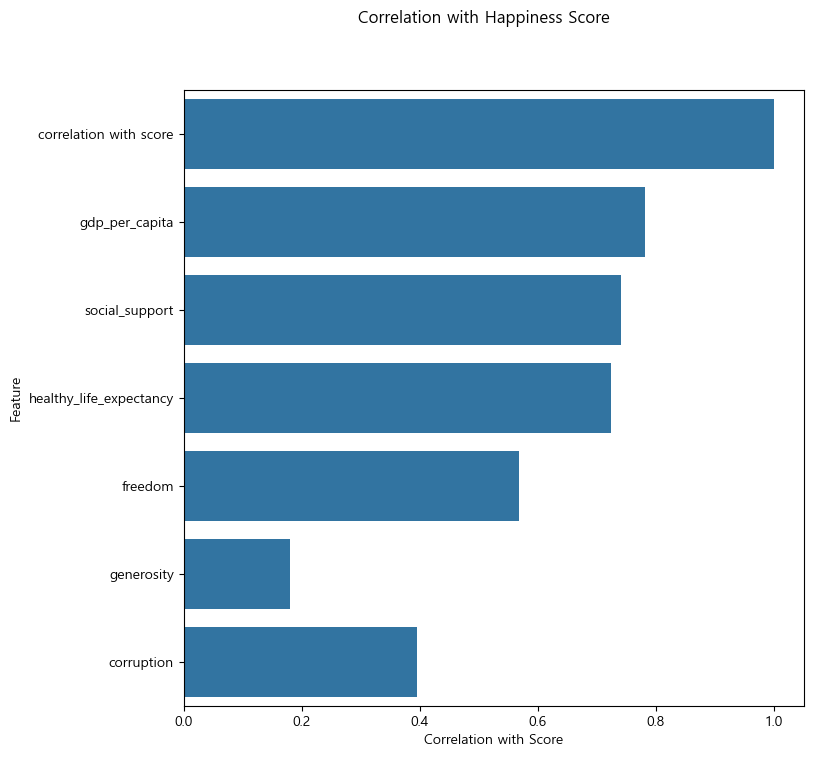

In [22]:
# 시각화 plot chart
plt.figure(figsize=(8,8))

sns.barplot(
    data=(
        corr_summary_df
        .reset_index()
        .rename(columns={'index' : 'feature'})
    ),
    x = 'correlation with score',
    y = 'feature',
    orient='h'
)

plt.suptitle('Correlation with Happiness Score')
plt.xlabel('Correlation with Score')
plt.ylabel('Feature')
plt.show()

##### heatmap chart

In [23]:
# 마스크: 윗 삼각형(대각선 위)을 숨기고 배경을 흰색으로 지정하기 위한 배열
mask_upper = np.triu(np.ones_like(corr_summary_df, dtype=bool), k=1)

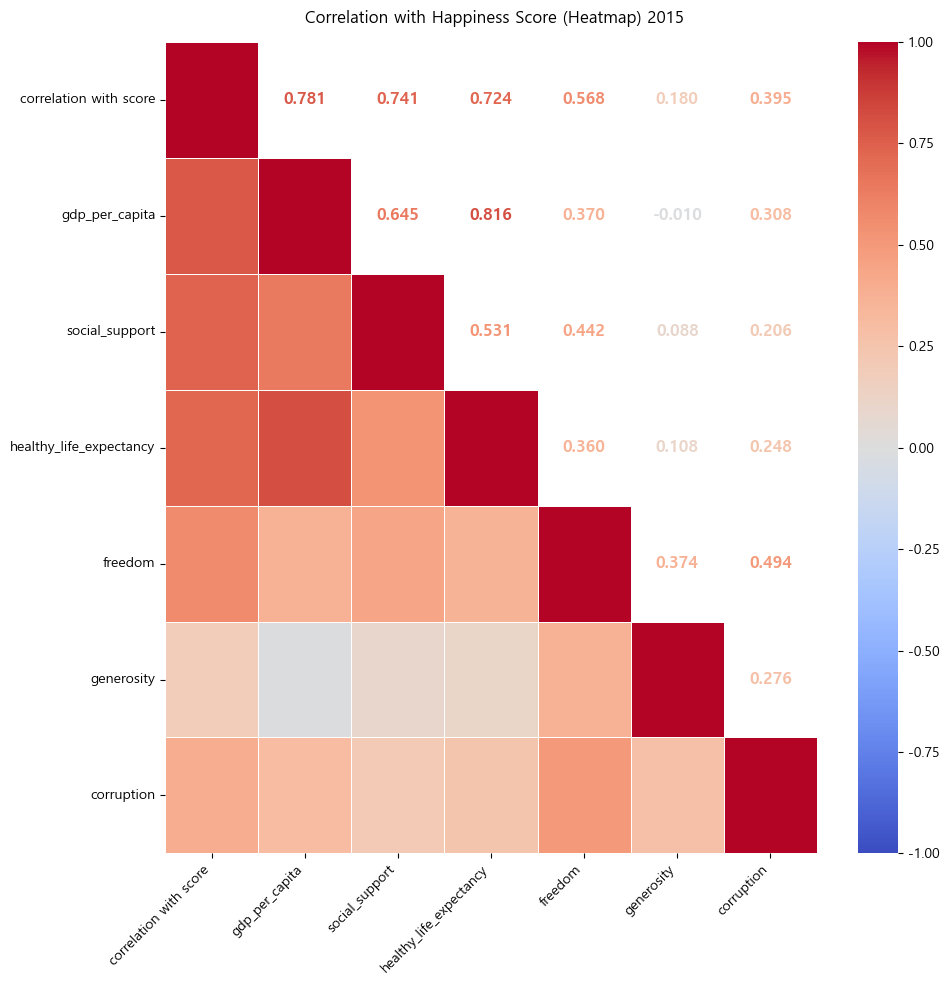

In [24]:
# 차트 생성
fig, ax = plt.subplots(figsize=(10, 10))

# heatmap을 1.0 아래 구역만 출력
sns.heatmap(
    corr_summary_df,
    mask=mask_upper,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    center=0,
    annot=False,
    linewidths=0.5,
    cbar=True,
    xticklabels=True, yticklabels=True,
    ax=ax,
)

# colormap & 정규화 객체
norm = mpl.colors.Normalize(vmin=-1, vmax=1)    # 상관 계수는 -1부터 1사이의 값 이므로 정규화 구간을 -1 ~ 1 사이로 설정
cmap = plt.get_cmap('coolwarm')                 # cmap을 plt에서 제공하는 coolwarm의 값을 취득

# 기존의 heatmap에서 1.0포함해서 위쪽 부분을 숫자로 출력
# ex: 'Correlation with Score'
row_idx = corr_summary_df.index.get_loc('correlation with score')

# 반목문으로 치환 작업
for i in range(len(corr_summary_df)):
    for j in range(i, len(corr_summary_df)):
        # dataframe에서 인덱스 지정으로 value를 취득
        value = corr_summary_df.iloc[i, j]

        # 해당 값의 색상을 지정
        rgba = cmap(norm(value))

        # 기존의 차트에 글자를 삽입
        ax.text(
            j + 0.5,
            i + 0.5,
            f'{value:.3f}',
            ha='center',
            va='center',
            fontdict={
                'color': rgba,
                'fontsize': 12,
                'fontweight': 'bold',
            },
    )

# 보기 좋게 x축 라벨을 45도 회전
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# title 설정
plt.suptitle('Correlation with Happiness Score (Heatmap) 2015')
plt.tight_layout()
plt.show()

#### Correlation Analysis (Based on Happiness Score) Summary

상관관계 시각화 결과로<br />
**1인당 GDP(Economy), 가족(Family), 기대 수명(Health)은 Happiness Score와 높은 양의 상관관계**를 보였다.<br /><br />
또한 **1인당 GDP와 기대 수명 간에도 상대적으로 강한 상관관계가 관찰**되었으며,<br />
이는 경제적 수준과 건강 지표가 행복 지수에 복합적으로 작용할 가능성을 시사한다.<br /><br />
이후 분석 단계에서는 양의 상관관계를 보인 **1인당 GDP, 기대 수명, 가족 지표를 중심으로** 추가 분석을 진행할 예정이다.<br /><br />

### Data Preparation & Merge

#### Data Preparation

In [25]:
# world_df select need columns copy
# world_df에서 ['NAME_EN', 'REGION_UN', 'SUBREGION', 'ECONOMY', 'ISO_A3', 'ADM0_A3', 'geometry']들을 복사
# ISO_A3는 국가 코드고 ADM0_A3는 분쟁 지역을 반영한 국가 코드다.
world_info_df = world_df.loc[
    :,
    ['NAME_EN', 'REGION_UN', 'SUBREGION', 'ECONOMY', 'ISO_A3', 'ADM0_A3', 'geometry']
].copy()

In [26]:
# dataframe split after dataframe structure
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   NAME_EN    177 non-null    str     
 1   REGION_UN  177 non-null    str     
 2   SUBREGION  177 non-null    str     
 3   ECONOMY    177 non-null    str     
 4   ISO_A3     177 non-null    str     
 5   ADM0_A3    177 non-null    str     
 6   geometry   177 non-null    geometry
dtypes: geometry(1), str(6)
memory usage: 9.8 KB


In [27]:
# dataframe columns rename
world_info_df = world_info_df.rename(
    columns={
        'NAME_EN': 'country', 'REGION_UN':'region',
        'SUBREGION': 'sub_region', 'ECONOMY': 'economy',
        'ISO_A3': 'ISO', 'ADM0_A3': 'ADM0'
    })

In [28]:
# rename after dataframe structure
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   country     177 non-null    str     
 1   region      177 non-null    str     
 2   sub_region  177 non-null    str     
 3   economy     177 non-null    str     
 4   ISO         177 non-null    str     
 5   ADM0        177 non-null    str     
 6   geometry    177 non-null    geometry
dtypes: geometry(1), str(6)
memory usage: 9.8 KB


#### merged for world_info_df into happiness_2015_df

In [29]:
# happiness_2015_df column add ISO code
# ISO코드를 부여하고 ISO가 중복인 경우에는 ADM0 코드를 부여
# - ADM0는 분쟁 지역에 부여하는 국가 코드

# ISO코드가 중복되는 것을 ADM0 코드로 변경하고 country_code 컬럼에 할당
world_info_df["country_code"] = world_info_df["ISO"].where(
    world_info_df["ISO"].notna() & (world_info_df["ISO"] != "-99"),
    world_info_df["ADM0"]
)

In [30]:
# 결측치 확인
world_info_df['country_code'].isna().sum()

np.int64(0)

In [31]:
# 이상치 확인
world_info_df.groupby("country_code")["country"].nunique().sort_values(ascending=False).head(10)

country_code
AFG    1
AGO    1
ALB    1
ARE    1
ARG    1
ARM    1
ATA    1
ATF    1
AUS    1
AUT    1
Name: country, dtype: int64

In [32]:
# 병합 전 world_info_df 구조확인
world_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   country       177 non-null    str     
 1   region        177 non-null    str     
 2   sub_region    177 non-null    str     
 3   economy       177 non-null    str     
 4   ISO           177 non-null    str     
 5   ADM0          177 non-null    str     
 6   geometry      177 non-null    geometry
 7   country_code  177 non-null    str     
dtypes: geometry(1), str(7)
memory usage: 11.2 KB


In [33]:
# ISO코드 부여
happiness_2015_df["country_code"] = coco.convert(
    names=happiness_2015_df['country'],
    to="ISO3",
    not_found=None
)

In [34]:
# 중복되는 국가 코드 확인
dup_mask = happiness_2015_df['country_code'].duplicated(keep=False)

In [35]:
happiness_2015_df["country_code"].value_counts().loc[lambda x : x > 1]

country_code
CYP    2
Name: count, dtype: int64

In [36]:
# 1) ADM0를 happiness_2015_df에 붙이기
happiness_2015_df = happiness_2015_df.merge(
    world_info_df[["country", "ADM0"]],
    on="country",
    how="left",
    suffixes=("", "_world")
)

In [37]:
# 3) 중복인 곳만 ADM0로 덮어쓰기
happiness_2015_df.loc[dup_mask, "country_code"] = (
    happiness_2015_df.loc[dup_mask, "ADM0"].combine_first(
        happiness_2015_df.loc[dup_mask, "country_code"]
    )
)

In [38]:
# 중복값 확인
happiness_2015_df["ADM0"].value_counts().loc[lambda x : x > 1]

Series([], Name: count, dtype: int64)

##### summary
키프로스트는 현재 북 키프로스트와 분재 지역이여서 세계지도 시각화 시에 제외하고 사용

In [39]:
# 중복되는 컬럼 확인
overlap_cols = world_info_df.columns.intersection(happiness_2015_df.columns)

In [40]:
overlap_cols

Index(['country', 'ADM0', 'country_code'], dtype='str')

In [41]:
# 병합할때 기준이 되는 열
key = 'country_code'

# 열이름을 다시 지정
happiness_2015_clean_df = happiness_2015_df.rename(
    columns={c : f'{c}_happiness' for c in overlap_cols if c != key}
).copy()

In [42]:
happiness_2015_clean_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     158 non-null    int64  
 1   country_happiness        158 non-null    str    
 2   rank                     158 non-null    int64  
 3   score                    158 non-null    float64
 4   gdp_per_capita           158 non-null    float64
 5   social_support           158 non-null    float64
 6   healthy_life_expectancy  158 non-null    float64
 7   freedom                  158 non-null    float64
 8   generosity               158 non-null    float64
 9   corruption               158 non-null    float64
 10  country_code             158 non-null    str    
 11  ADM0_happiness           143 non-null    str    
dtypes: float64(7), int64(2), str(3)
memory usage: 14.9 KB


In [43]:
# meagre 진행
happiness_2015_geo_df = world_info_df.merge(
    happiness_2015_clean_df,
    how="left",
    on=key
).copy()

In [44]:
# merge 후 데이터 구조 파악
happiness_2015_geo_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   country                  178 non-null    str     
 1   region                   178 non-null    str     
 2   sub_region               178 non-null    str     
 3   economy                  178 non-null    str     
 4   ISO                      178 non-null    str     
 5   ADM0                     178 non-null    str     
 6   geometry                 178 non-null    geometry
 7   country_code             178 non-null    str     
 8   year                     151 non-null    float64 
 9   country_happiness        151 non-null    str     
 10  rank                     151 non-null    float64 
 11  score                    151 non-null    float64 
 12  gdp_per_capita           151 non-null    float64 
 13  social_support           151 non-null    float64 
 14  he

In [45]:
# Geometry 활성화
happiness_2015_geo_df = happiness_2015_geo_df.set_geometry('geometry')

In [46]:
# 활성화 확인
happiness_2015_geo_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### visualization

#### happiness score

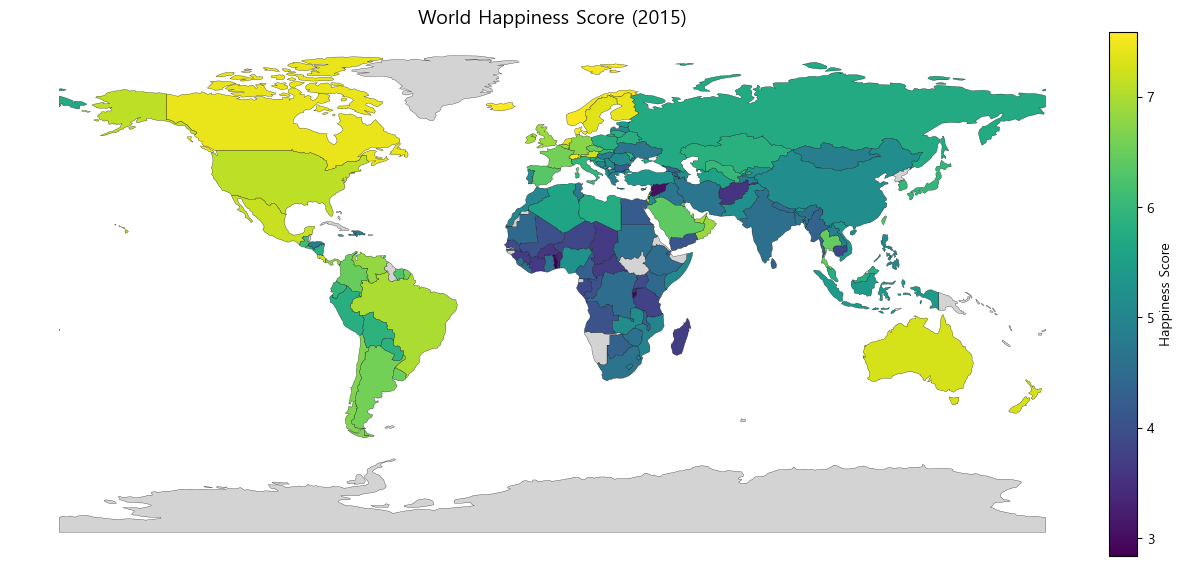

In [47]:
# 1) figure/ax 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 2) 먼저 지도만 그리기 (legend=False)
happiness_2015_geo_df.plot(
    column="score",
    ax=ax,
    cmap="viridis",
    legend=False,
    linewidth=0.2,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)

ax.set_title("World Happiness Score (2015)", fontsize=14)
ax.set_axis_off()

# 3) ax와 같은 높이로 colorbar 영역(cax) 만들기
pos = ax.get_position()               # 지도 축의 위치(figure 좌표)
pad = 0.01                            # 지도와 바 사이 간격(figure 비율)
cbar_w = 0.02                         # colorbar 너비(figure 비율)

cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

# 4) colorbar 생성 (mappable은 plot 결과에서 가져오기)
mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Score")

plt.show()

#### happiness rank

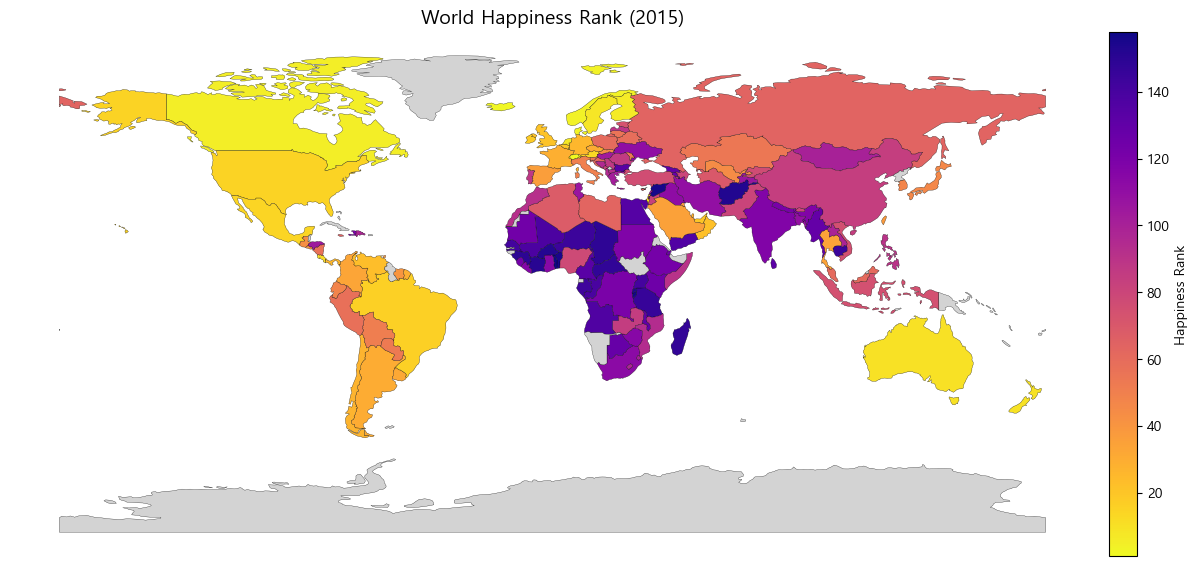

In [48]:
# 1) figure/ax 생성
fig, ax = plt.subplots(figsize=(14, 8))

# 2) 지도 그리기
happiness_2015_geo_df.plot(
    column="rank",
    ax=ax,
    cmap="plasma_r",  # ⭐ reversed plasma
    legend=False,
    linewidth=0.2,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)

ax.set_title("World Happiness Rank (2015)", fontsize=14)
ax.set_axis_off()

# 3) colorbar 영역 생성
pos = ax.get_position()
pad = 0.01
cbar_w = 0.02

cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

# 4) colorbar 생성
mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Rank")

plt.show()

#### Region for asia

##### Happiness Score

In [49]:
# =========================
# 1) 대략적인 아시아 영역 (시베리아 포함)
# =========================
asia_bbox = box(30, 0, 180, 80)  # (min_lon, min_lat, max_lon, max_lat)

In [50]:
# =========================
# 2) 아시아 + 러시아 추출
# =========================
happiness_2015_asia_df = happiness_2015_geo_df[happiness_2015_geo_df["region"] == "Asia"]
happiness_2015_russia_df = happiness_2015_geo_df[happiness_2015_geo_df["ISO"] == "RUS"]

# (안전) geometry 활성화가 혹시 풀렸을 때 대비
if "geometry" in happiness_2015_asia_df.columns:
    happiness_2015_asia_df = happiness_2015_asia_df.set_geometry("geometry")
if "geometry" in happiness_2015_russia_df.columns:
    happiness_2015_russia_df = happiness_2015_russia_df.set_geometry("geometry")


In [51]:
# =========================
# 3) Clip용 bbox GeoDataFrame
# =========================
asia_bbox_gdf = gpd.GeoDataFrame(
    geometry=[asia_bbox],
    crs=happiness_2015_geo_df.crs  # geo df의 crs를 따르는 게 가장 안전
)

In [52]:
# =========================
# 4) 러시아 중 아시아 bbox에 걸치는 부분(시베리아)만 clip
# =========================
russia_asia = gpd.clip(happiness_2015_russia_df, asia_bbox_gdf)

In [53]:
# =========================
# 5) 아시아 + 시베리아 합치기 (GeoDataFrame 유지)
# =========================
asia_with_siberia = gpd.GeoDataFrame(
    pd.concat([happiness_2015_asia_df, russia_asia], ignore_index=True),
    geometry="geometry",
    crs=happiness_2015_geo_df.crs
)

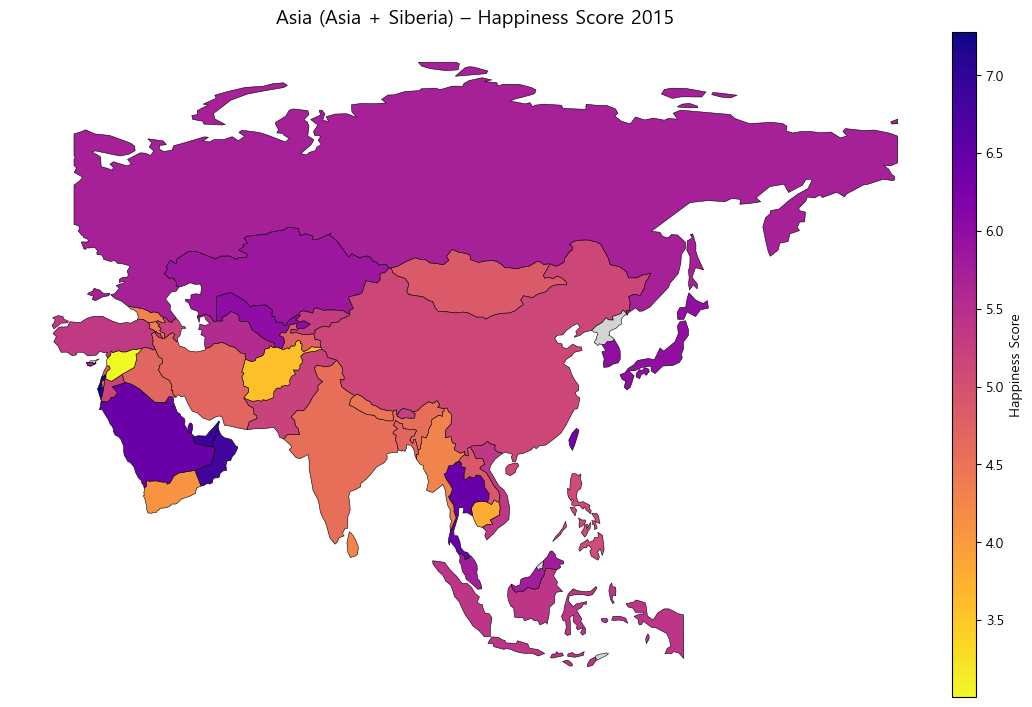

In [54]:
# =========================
# 6) Plot: Happiness Score + colorbar
# =========================
fig, ax = plt.subplots(figsize=(12, 12))

asia_with_siberia.plot(
    column='score',
    ax=ax,
    cmap="plasma_r",
    edgecolor="black",
    linewidth=0.4,
    legend=False,  # colorbar는 수동으로
    missing_kwds={"color": "lightgrey"}
)

ax.set_title('Asia (Asia + Siberia) – Happiness Score 2015', fontsize=14)
ax.set_axis_off()

# --- colorbar (ax 높이 맞춤) ---
pos = ax.get_position()
pad = 0.01
cbar_w = 0.02
cax = fig.add_axes([pos.x1 + pad, pos.y0, cbar_w, pos.height])

mappable = ax.collections[0]
cbar = fig.colorbar(mappable, cax=cax)
cbar.set_label("Happiness Score")

plt.show()

#### Visualization Summary

2015년도 조사자료 기준으로 **북유럽(Northern Europe)과 북아메리카(North America) 지역이 행복지수가 높게** 나오고있다.<br />
또한 **아시아(Asia) 내부에서도 1인당 GDP가 높은 중동 지역이 행복지수가 높게** 나오고 있다.<br />
허나 **태국**처럼 1인당 GDP 수준만으로 설명하기 어려운 예외 사례가 존재하므로<br />
단순 비교보다는 **GDP·사회적 지원·기대수명·자유·부패 인식**등과 함계 **상관관계 및 다변량 관점에서 분석이 필요하다.**

### Correlation Analysis Between Happiness Score and Socioeconomic Indicators

#### GDP Correlation Analysis

In [55]:
# happiness_2015_df에서 문자열과 Rank, Strander Error를 제외하고 Score에 관련한 상관관계를 분리
happiness_2015_numeric_df = happiness_2015_df.select_dtypes(include='number').copy()

In [56]:
# rank와 year 컬럼 제거
happiness_2015_numeric_df.drop(columns=['rank', 'year'], inplace=True)

In [57]:
# data structure
happiness_2015_numeric_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   score                    158 non-null    float64
 1   gdp_per_capita           158 non-null    float64
 2   social_support           158 non-null    float64
 3   healthy_life_expectancy  158 non-null    float64
 4   freedom                  158 non-null    float64
 5   generosity               158 non-null    float64
 6   corruption               158 non-null    float64
dtypes: float64(7)
memory usage: 8.8 KB


##### visualization

In [58]:
# mean
gpd_mean = happiness_2015_numeric_df['gdp_per_capita'].mean()
score_mean = happiness_2015_numeric_df['score'].mean()

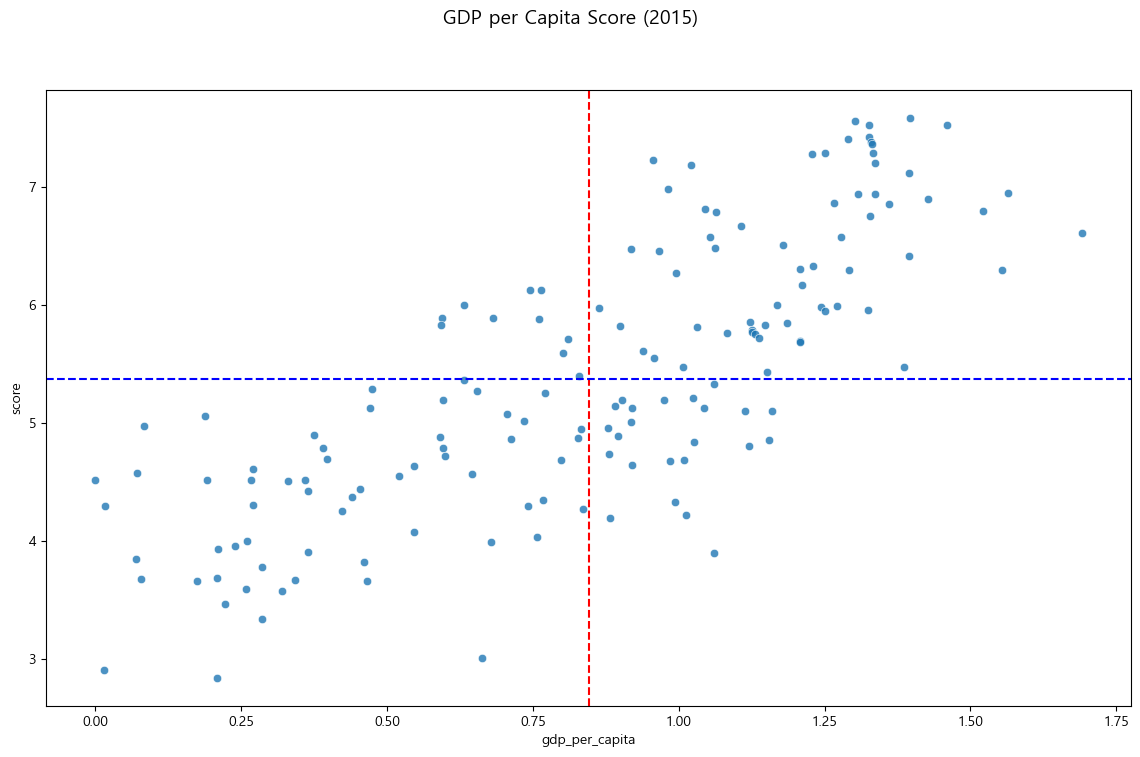

In [59]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'gdp_per_capita',
    y = 'score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=gpd_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Economy (GDP per Capita)")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('GDP per Capita Score (2015)', fontsize=14)
plt.show()

##### summary for GDP

그래프 기준으로 **좌상단(저 GDP·고 행복)과 우하단(고 GDP·저 행복)에 위치한 국가들**은<br /> 행복지수가 GDP 수준만으로는 충분히 설명되지 않는 예외 사례로 해석할 수 있다.<br /><br />
반면, **우상단(고 GDP·고 행복)과 좌하단(저 GDP·저 행복)에 분포한 국가들**은<br />
GDP와 행복지수 간의 전반적인 양의 상관관계 흐름을 따르는 경향을 보인다.<br /><br />
따라서 이후 분석에서는 이러한 예외 국가를 별도로 고려하고,
**GDP 이외의 요인(사회적 지원, 기대수명, 자유, 부패 인식 등)을 포함한 다변량 관점의 상관관계 분석이 필요**하다.

#### social_support Correlation Analysis

##### visualization

In [60]:
# mean
social_support_mean = happiness_2015_numeric_df['social_support'].mean()

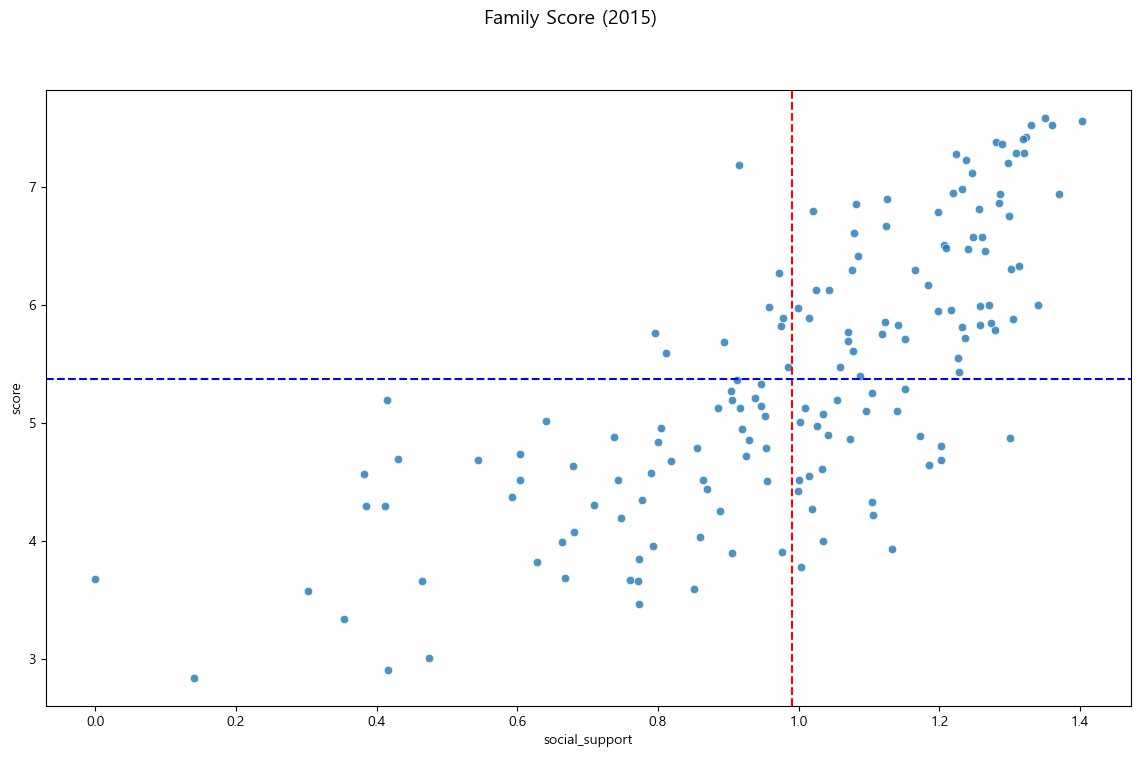

In [61]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'social_support',
    y = 'score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=social_support_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Family")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('Family Score (2015)', fontsize=14)
plt.show()

##### summary

가족(Family) 지표 역시 전반적으로 행복지수와 양의 상관관계를 보이지만,<br />
**우하단(가족 점수는 높으나 행복지수가 낮은 국가)에 위치한 사례가 관측**된다.<br />
이는 가족 요인만으로는 행복지수를 충분히 설명하기 어려운 예외적 패턴이 존재함을 의미하며,<br />
이후 분석에서는 기대수명 등 다른 요인들과의 상관관계를 함께 고려한 분석이 필요하다.

#### health

##### visualization

In [62]:
# mean
health_mean = happiness_2015_numeric_df['healthy_life_expectancy'].mean()

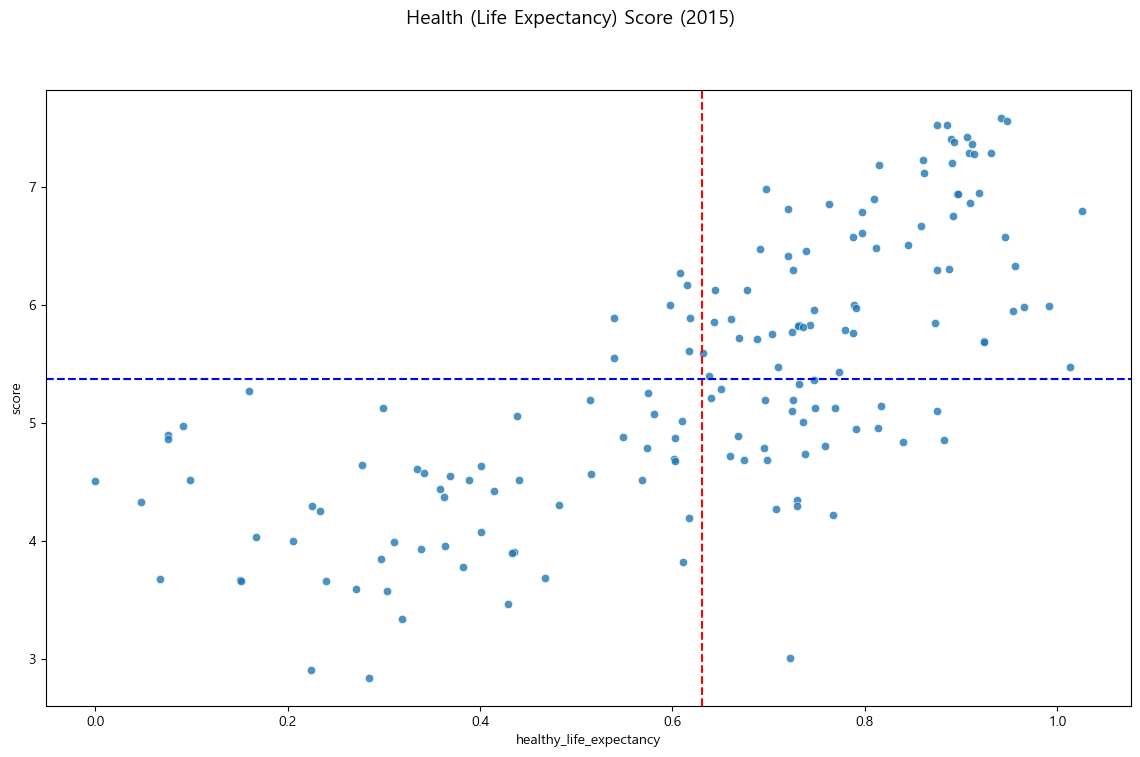

In [63]:
# scatter chart
plt.figure(figsize=(14, 8))

# scatter plot
sns.scatterplot(
    data=happiness_2015_numeric_df,
    x = 'healthy_life_expectancy',
    y = 'score',
    alpha=0.8,
)

# 평균선 추가
plt.axvline(x=health_mean, color="red", linestyle="--", linewidth=1.5, label="Mean Health (Life Expectancy)")
plt.axhline(y=score_mean, color="blue", linestyle="--", linewidth=1.5, label="Mean Happiness Score)")

# title
plt.suptitle('Health (Life Expectancy) Score (2015)', fontsize=14)
plt.show()

##### summary

기대수명(Health, Life Expectancy) 지표는 전반적으로 행복지수와 양의 상관관계를 보이지만,<br />
평균 기대수명 이상인 국가들 사이에서도 행복지수의 분산이 크게 나타난다.<br />
특히 **기대수명이 높음에도 평균 이하의 행복지수를 보이는 국가들이 존재**하여,<br />
기대수명 단일 지표만으로는 행복지수를 충분히 설명하기 어렵다는 점을 확인할 수 있다.<br />
따라서 기대수명은 행복지수에 **보조적인 영향을 미치는 요인으로 해석**되며,<br />
GDP 및 Family와 같은 다른 사회·경제적 요인과 함께 고려한 **다변량 분석이 필요**하다.

#### Correlation 3D visualization

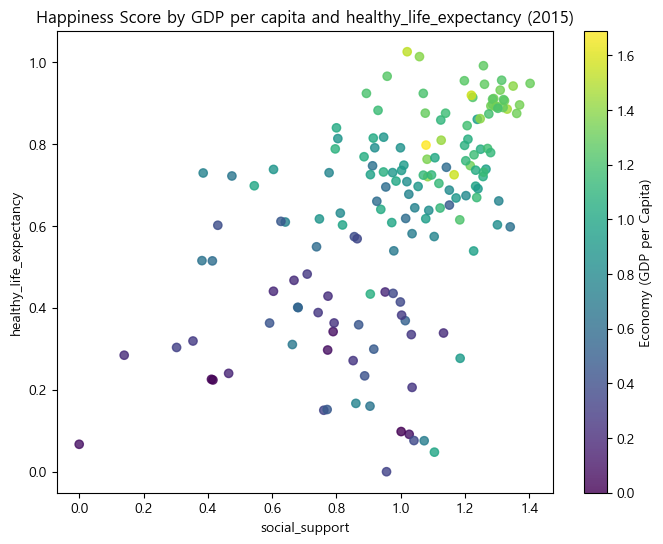

In [64]:
# GDP (Health and Family
plt.figure(figsize=(8, 6))
plt.scatter(
    happiness_2015_df["social_support"],
    happiness_2015_df["healthy_life_expectancy"],
    c=happiness_2015_df["gdp_per_capita"],
    cmap="viridis",
    alpha=0.8
)

plt.xlabel("social_support")
plt.ylabel("healthy_life_expectancy")
plt.title("Happiness Score by GDP per capita and healthy_life_expectancy (2015)")
plt.colorbar(label="Economy (GDP per Capita)")
plt.show()

##### summary

Family와 Health(기대수명)를 함께 고려한 산점도 분석 결과,<br />
**Family와 Health 수준이 모두 높은 국가들에서 GDP per capita가 높게 분포하는 경향**이 관측된다.<br />
이는 GDP가 단일 요인보다는 **Family 및 Health와 강하게 연관된 변수군과 함께 움직이는 구조**를 가짐을 시사한다.<br />
따라서 2015년 기준 데이터에서는 **GDP, Family, Health가 상호 밀접하게 연관된 핵심 설명 변수 군집**을 형성하고 있음을 확인할 수 있다.

### GDP로 설명이 안되는 국가들

#### Classifier Linear Regression model

In [65]:
# 선형 회귀 모델
from sklearn.linear_model import LinearRegression

In [66]:
# X는 score에 상호 밀접하게 나타나는 gdp_per_capita를 지정
# y는 Happiness Score를 지정
X = happiness_2015_numeric_df[['gdp_per_capita']]
y = happiness_2015_numeric_df['score']

In [67]:
# 모델에 선형 회귀 지정
model = LinearRegression()

In [68]:
# 분류를 위해서 선형회귀 훈련
model.fit(X,y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


#### gdp pred and gdp residual columns add

In [69]:
# 구분 하기 위해서 gdb를 예측해서 gdp_pred 칼럼에 저장
happiness_2015_numeric_df['gdp_pred'] = model.predict(X)
# 분류 하기 위해서 원래 점수에서 예측 값을 뺸 값을 gdp_residual에 자장
happiness_2015_numeric_df['gdp_residual'] = y -  happiness_2015_numeric_df['gdp_pred']

In [70]:
threshold = happiness_2015_numeric_df['gdp_residual'].abs().quantile(0.8)

In [71]:
# gdp에 영향을 안 받는 행을 추출해서 gdp_outliers_df에 저장
gdp_outliers_df = happiness_2015_numeric_df[
    happiness_2015_numeric_df['gdp_residual'].abs() >= threshold
].copy()

In [72]:
# dataframe 확인
gdp_outliers_df.head()

,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption,gdp_pred,gdp_residual
0,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,6.596586,0.990414
1,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,6.387651,1.173349
2,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,6.439025,1.087975
4,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,6.440822,0.986178
5,7.406,1.29025,1.31826,0.88911,0.64169,0.23351,0.41372,6.360877,1.045123


#### outlier correlation

In [73]:
# 사용할 칼럼들 등록
cols = [
    "score",
    "social_support",
    "healthy_life_expectancy",
    "freedom",
    "corruption",
    "generosity",
]

In [74]:
# gdp에 영향을 받지 않는 데이터를 기준으로 상관 관계 계산
outlier_corr = (
    gdp_outliers_df[cols]
    .corr(numeric_only=True)["score"]
    .sort_values(ascending=False)
)

In [75]:
outlier_corr.head()

score                      1.000000
social_support             0.799949
freedom                    0.692898
healthy_life_expectancy    0.631471
corruption                 0.511901
Name: score, dtype: float64

#### visualization

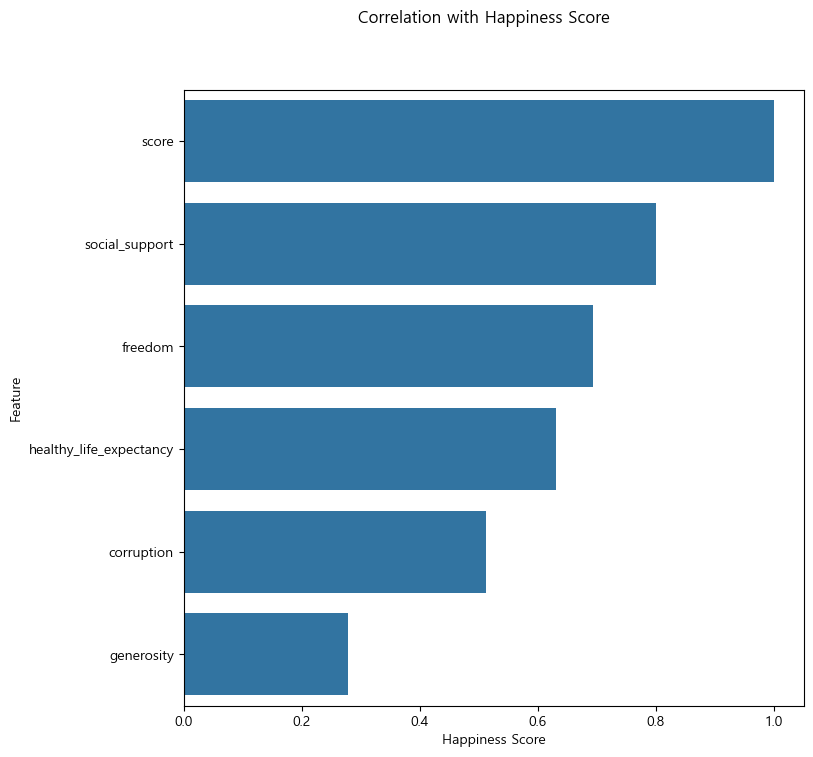

In [76]:
# 시각화 plot chart
plt.figure(figsize=(8,8))

sns.barplot(
    data=(
        outlier_corr
        .reset_index()
        .rename(columns={'index' : 'feature'})
    ),
    x = 'score',
    y = 'feature',
    orient='h'
)

plt.suptitle('Correlation with Happiness Score')
plt.xlabel('Happiness Score')
plt.ylabel('Feature')
plt.show()

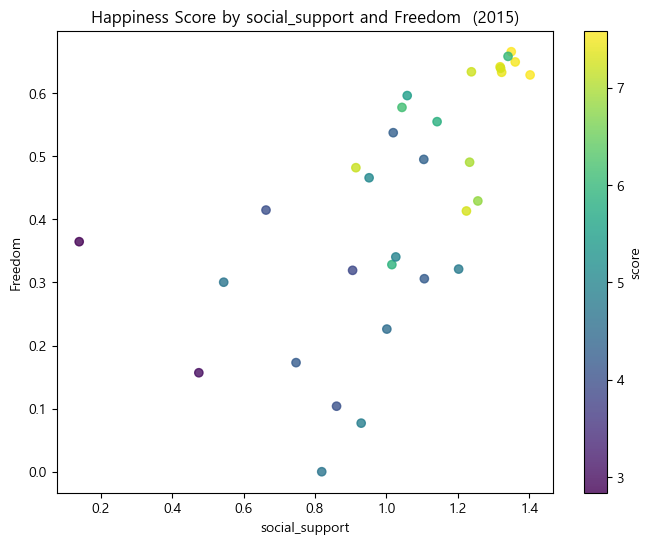

In [77]:
# social_support and freedom
plt.figure(figsize=(8, 6))
plt.scatter(
    gdp_outliers_df["social_support"],
    gdp_outliers_df["freedom"],
    c=gdp_outliers_df["score"],
    cmap="viridis",
    alpha=0.8
)

plt.xlabel("social_support")
plt.ylabel("Freedom")
plt.title("Happiness Score by social_support and Freedom  (2015)")
plt.colorbar(label="score")
plt.show()

#### summary

GDP로 설명되지 않는 국가 집단을 대상으로 추가 분석한 결과,<br />
가족(Family)과 자유(Freedom)가 동시에 높은 국가들에서<br />
상대적으로 높은 행복지수가 관측되었다.<br />
또한 기대수명(Health)은 이러한 관계를 보완하는 요인으로 작용하며,<br />
행복지수는 단일 변수보다 사회적 요인의 결합 구조에 의해 형성되는 경향을 보였다.<br />
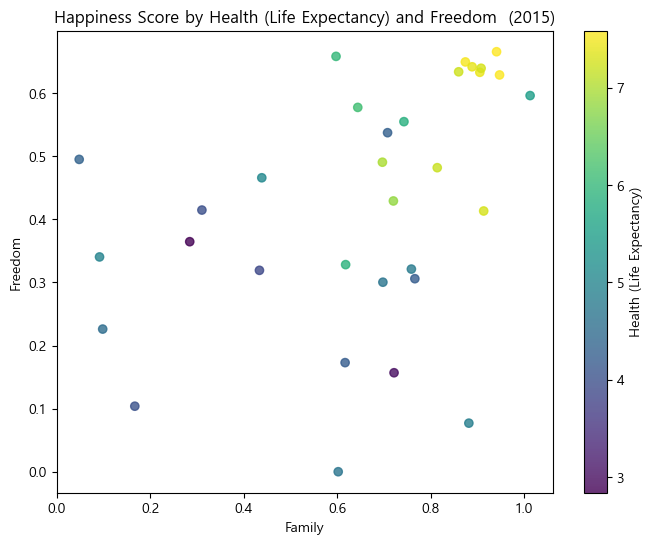

In [78]:
def build_volatility_metrics(happiness_df: pd.DataFrame) -> pd.DataFrame:
    """
    국가별 행복지수 변동성(순위/점수)의 요약 지표를 계산한다.

    Metrics
    -------
    - n_years: 관측된 연도 수
    - rank_jump_mean: 연도 간 평균 |Δrank|
    - rank_jump_max: 연도 간 최대 |Δrank|
    - rank_std: 전체 기간 rank 표준편차
    - score_std: 전체 기간 score 표준편차
    - delta_2015_2024_rank: 2024 rank - 2015 rank (음수면 순위 개선)
    - delta_2015_2024_score: 2024 score - 2015 score

    Parameters
    ----------
    happiness_df : pd.DataFrame
        통합/표준화된 데이터프레임(연도, 국가, rank, score 포함).

    Returns
    -------
    pd.DataFrame
        국가별 변동성 지표 데이터프레임.
    """
    years = sorted(happiness_df["year"].unique())
    panel_rank_df = happiness_df.pivot_table(index="country", columns="year", values="rank", aggfunc="mean")
    panel_score_df = happiness_df.pivot_table(index="country", columns="year", values="score", aggfunc="mean")

    rank_diff_df = panel_rank_df[years].diff(axis=1).abs()

    vol_df = pd.DataFrame(index=panel_rank_df.index)
    vol_df["n_years"] = panel_rank_df.notna().sum(axis=1)
    vol_df["rank_jump_mean"] = rank_diff_df.mean(axis=1, skipna=True)
    vol_df["rank_jump_max"] = rank_diff_df.max(axis=1, skipna=True)
    vol_df["rank_std"] = panel_rank_df.std(axis=1, skipna=True)
    vol_df["score_std"] = panel_score_df.std(axis=1, skipna=True)

    if 2015 in panel_rank_df.columns and 2024 in panel_rank_df.columns:
        vol_df["delta_2015_2024_rank"] = panel_rank_df[2024] - panel_rank_df[2015]  # (-)면 순위 개선
    if 2015 in panel_score_df.columns and 2024 in panel_score_df.columns:
        vol_df["delta_2015_2024_score"] = panel_score_df[2024] - panel_score_df[2015]

    return vol_df.reset_index().rename(columns={"index": "country"})

In [79]:
volatility_df = build_volatility_metrics(happiness_df)
display(volatility_df.sort_values("rank_jump_mean", ascending=False).head(10))

,country,n_years,rank_jump_mean,rank_jump_max,rank_std,score_std,delta_2015_2024_rank,delta_2015_2024_score
2,Algeria,10,14.777778,31.0,21.704070,0.437445,17.0,-0.241
192,Venezuela,10,14.666667,38.0,29.051678,0.662739,56.0,-1.203
157,Somalia,4,12.000000,17.0,14.863266,0.322712,NaN,NaN
128,Nigeria,10,11.777778,30.0,13.571211,0.239627,24.0,-0.387
135,Pakistan,10,11.666667,39.0,19.287590,0.433600,27.0,-0.537
107,Malaysia,10,11.555556,45.0,16.850981,0.340180,-2.0,0.205
93,Lebanon,10,11.444444,22.0,23.952731,1.156797,39.0,-2.132
16,Benin,10,11.000000,34.0,23.647645,0.656689,-39.0,1.037
62,Ghana,10,10.444444,23.0,12.896597,0.359142,6.0,-0.344
82,Jamaica,10,10.000000,26.0,10.999495,0.264078,2.0,0.133


In [80]:
TOP_N = 15  # 여기만 바꾸면 됨

In [81]:
top_vol_df = (
    volatility_df.dropna(subset=["rank_jump_mean"])
    .query("n_years >= 6")  # 관측 연도 너무 적은 국가는 제외(원하면 조정)
    .sort_values("rank_jump_mean", ascending=False)
    .head(TOP_N)
)

In [82]:
display(top_vol_df[[
    "country", "n_years", "rank_jump_mean", "rank_jump_max", "rank_std", "score_std",
    "delta_2015_2024_rank", "delta_2015_2024_score"
]])

,country,n_years,rank_jump_mean,rank_jump_max,rank_std,score_std,delta_2015_2024_rank,delta_2015_2024_score
2,Algeria,10,14.777778,31.0,21.704070,0.437445,17.0,-0.241
192,Venezuela,10,14.666667,38.0,29.051678,0.662739,56.0,-1.203
128,Nigeria,10,11.777778,30.0,13.571211,0.239627,24.0,-0.387
135,Pakistan,10,11.666667,39.0,19.287590,0.433600,27.0,-0.537
107,Malaysia,10,11.555556,45.0,16.850981,0.340180,-2.0,0.205
93,Lebanon,10,11.444444,22.0,23.952731,1.156797,39.0,-2.132
16,Benin,10,11.000000,34.0,23.647645,0.656689,-39.0,1.037
62,Ghana,10,10.444444,23.0,12.896597,0.359142,6.0,-0.344
96,Liberia,9,10.000000,34.0,14.053469,0.456592,5.0,-0.302
82,Jamaica,10,10.000000,26.0,10.999495,0.264078,2.0,0.133


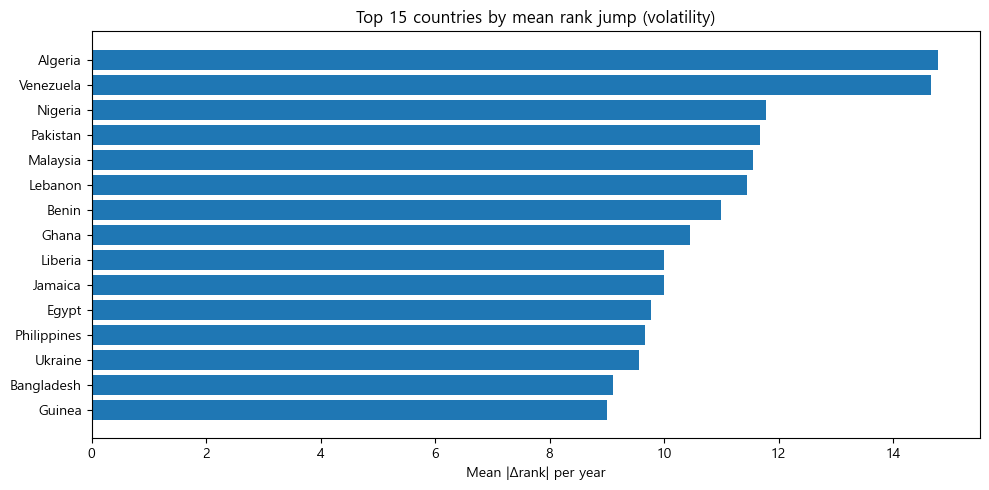

In [83]:
plt.figure(figsize=(10, 5))
plt.barh(top_vol_df["country"], top_vol_df["rank_jump_mean"])
plt.title(f"Top {TOP_N} countries by mean rank jump (volatility)")
plt.xlabel("Mean |Δrank| per year")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [84]:
focus_countries = top_vol_df["country"].tolist()

In [85]:
focus_df = happiness_df[happiness_df["country"].isin(focus_countries)].copy()

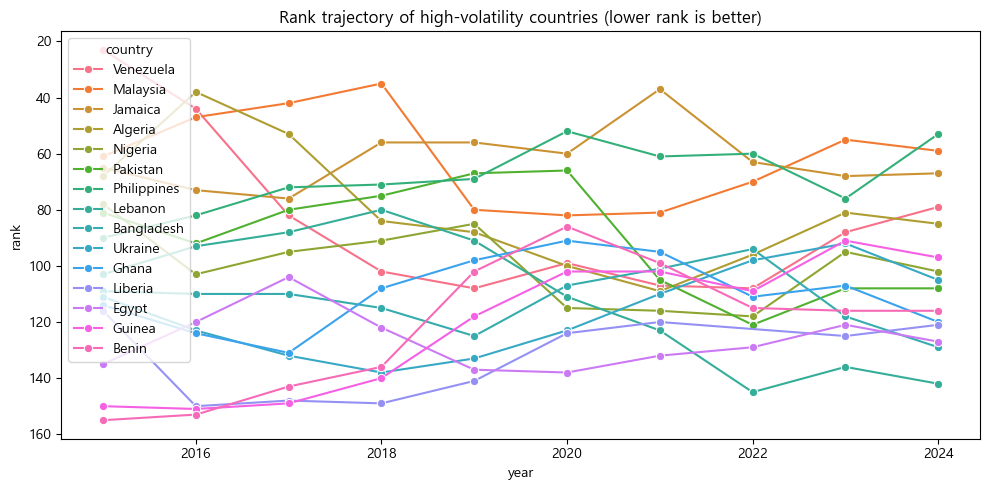

In [86]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=focus_df, x="year", y="rank", hue="country", marker="o")
plt.gca().invert_yaxis()
plt.title("Rank trajectory of high-volatility countries (lower rank is better)")
plt.tight_layout()
plt.show()

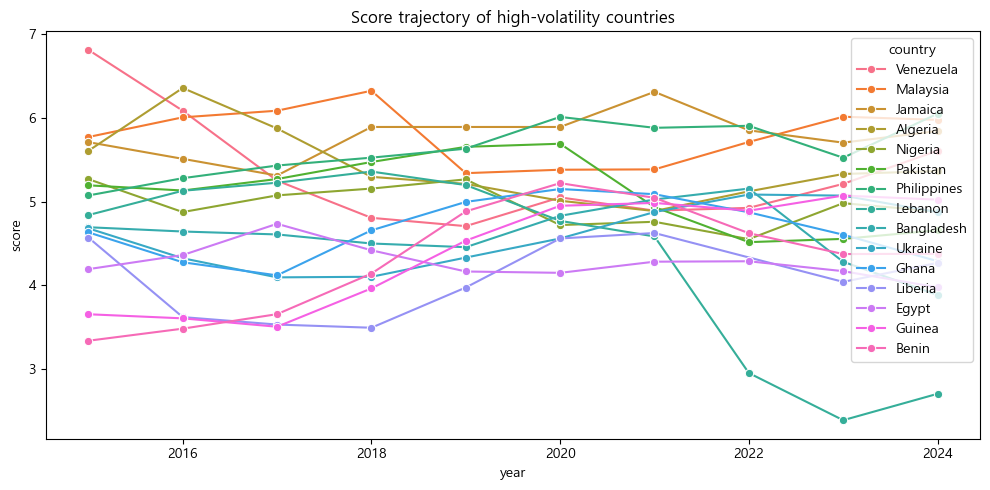

In [87]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=focus_df, x="year", y="score", hue="country", marker="o")
plt.title("Score trajectory of high-volatility countries")
plt.tight_layout()
plt.show()

In [88]:
pre_df = happiness_df[(happiness_df["year"] >= 2015) & (happiness_df["year"] <= 2019)].dropna(subset=["score"]).copy()

In [89]:
post_df = happiness_df[(happiness_df["year"] >= 2020) & (happiness_df["year"] <= 2024)].dropna(subset=["score"]).copy()

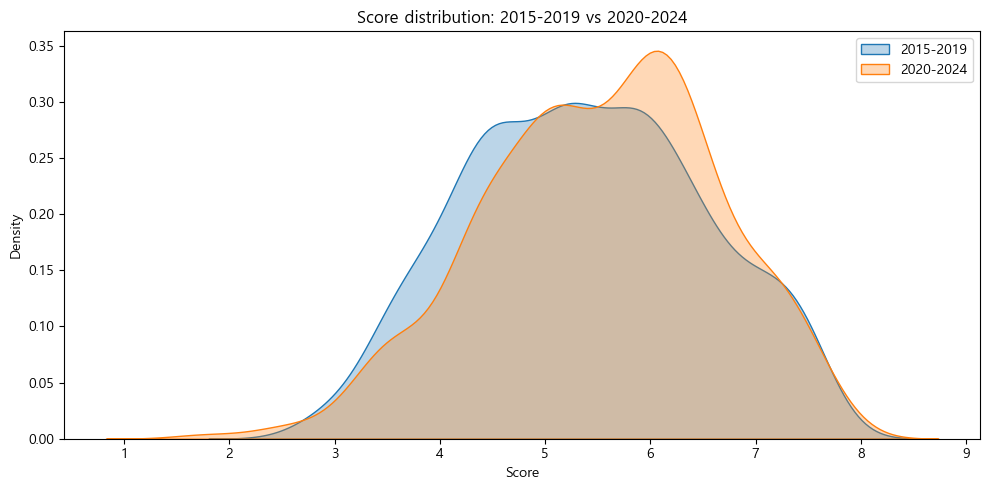

In [90]:
# (1) KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(pre_df["score"], label="2015-2019", fill=True, alpha=0.3)
sns.kdeplot(post_df["score"], label="2020-2024", fill=True, alpha=0.3)
plt.title("Score distribution: 2015-2019 vs 2020-2024")
plt.xlabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

In [91]:
tmp_df = pd.concat(
    [pre_df.assign(period="2015-2019"), post_df.assign(period="2020-2024")],
    ignore_index=True
)

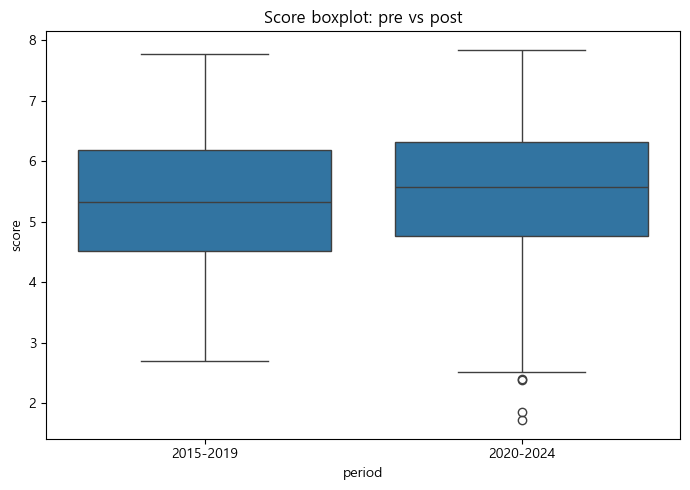

In [92]:
plt.figure(figsize=(7, 5))
sns.boxplot(data=tmp_df, x="period", y="score")
plt.title("Score boxplot: pre vs post")
plt.tight_layout()
plt.show()

In [93]:
# (3) 요약 통계(분산/꼬리)
def dist_summary(score_s: pd.Series) -> dict:
    s = score_s.dropna()
    return {
        "n": len(s),
        "mean": s.mean(),
        "std": s.std(),
        "q10": s.quantile(0.10),
        "q50": s.quantile(0.50),
        "q90": s.quantile(0.90),
        "iqr": s.quantile(0.75) - s.quantile(0.25),
        "skew": stats.skew(s, nan_policy="omit"),
        "kurtosis": stats.kurtosis(s, nan_policy="omit"),
    }

In [94]:
summary_df = pd.DataFrame([dist_summary(pre_df["score"]), dist_summary(post_df["score"])], index=["2015-2019", "2020-2024"])

In [95]:
display(summary_df)

,n,mean,std,q10,q50,q90,iqr,skew,kurtosis
2015-2019,782,5.379018,1.127456,3.8771,5.322,6.9637,1.67975,0.035791,-0.763860
2020-2024,728,5.524740,1.113797,4.1176,5.583,6.9686,1.55550,-0.294586,-0.254074


In [96]:
panel_rank_df = happiness_df.pivot_table(index="country", columns="year", values="rank", aggfunc="mean")

In [97]:
pre_years = [2015, 2016, 2017, 2018, 2019]
post_years = [2020, 2021, 2022, 2023, 2024]

In [98]:
def mean_rank_jump(panel_df: pd.DataFrame, years: list[int]) -> pd.Series:
    """
    pivot된 rank 패널 데이터(panel_df)에서 선택한 years 구간의 평균 순위 점프(|Δrank|)를 계산한다.

    Parameters
    ----------
    panel_df : pd.DataFrame
        index=country, columns=year, values=rank 형태의 패널 데이터.
    years : list[int]
        계산에 사용할 연도 리스트(정렬된 상태 권장).

    Returns
    -------
    pd.Series
        국가별 mean |Δrank| 값.
    """
    diff_df = panel_df[years].diff(axis=1).abs()
    return diff_df.mean(axis=1, skipna=True)

In [99]:
vol_pre_s = mean_rank_jump(panel_rank_df, pre_years)
vol_post_s = mean_rank_jump(panel_rank_df, post_years)

In [100]:
delta_vol_df = pd.DataFrame({
    "country": vol_pre_s.index,
    "pre_vol": vol_pre_s.values,
    "post_vol": vol_post_s.values,
})

In [101]:
delta_vol_df["delta_vol(post-pre)"] = delta_vol_df["post_vol"] - delta_vol_df["pre_vol"]
delta_vol_df = delta_vol_df.dropna()

In [102]:
display(delta_vol_df.sort_values("delta_vol(post-pre)", ascending=False).head(15))

,country,pre_vol,post_vol,delta_vol(post-pre)
10,Bahrain,4.00,15.00,11.00
11,Bangladesh,4.00,12.00,8.00
135,Pakistan,9.00,17.00,8.00
114,Mexico,3.25,10.75,7.50
141,Philippines,5.25,12.25,7.00
82,Jamaica,7.75,13.75,6.00
41,Croatia,6.75,12.00,5.25
34,Colombia,3.50,8.50,5.00
155,Slovakia,1.75,6.50,4.75
50,El Salvador,3.75,8.25,4.50


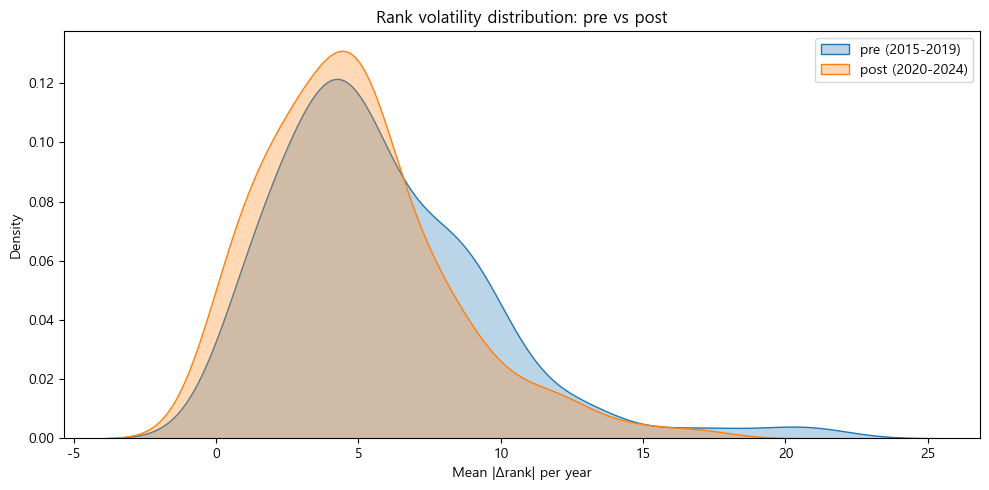

In [103]:
plt.figure(figsize=(10, 5))
sns.kdeplot(delta_vol_df["pre_vol"], label="pre (2015-2019)", fill=True, alpha=0.3)
sns.kdeplot(delta_vol_df["post_vol"], label="post (2020-2024)", fill=True, alpha=0.3)
plt.title("Rank volatility distribution: pre vs post")
plt.xlabel("Mean |Δrank| per year")
plt.legend()
plt.tight_layout()
plt.show()

In [104]:
paired_tt = stats.ttest_rel(delta_vol_df["pre_vol"], delta_vol_df["post_vol"], nan_policy="omit")

In [105]:
print(f"paired t-test (pre vs post volatility):\n {paired_tt}")

paired t-test (pre vs post volatility):
 TtestResult(statistic=np.float64(2.8421905215756054), pvalue=np.float64(0.00513626365124672), df=np.int64(143))


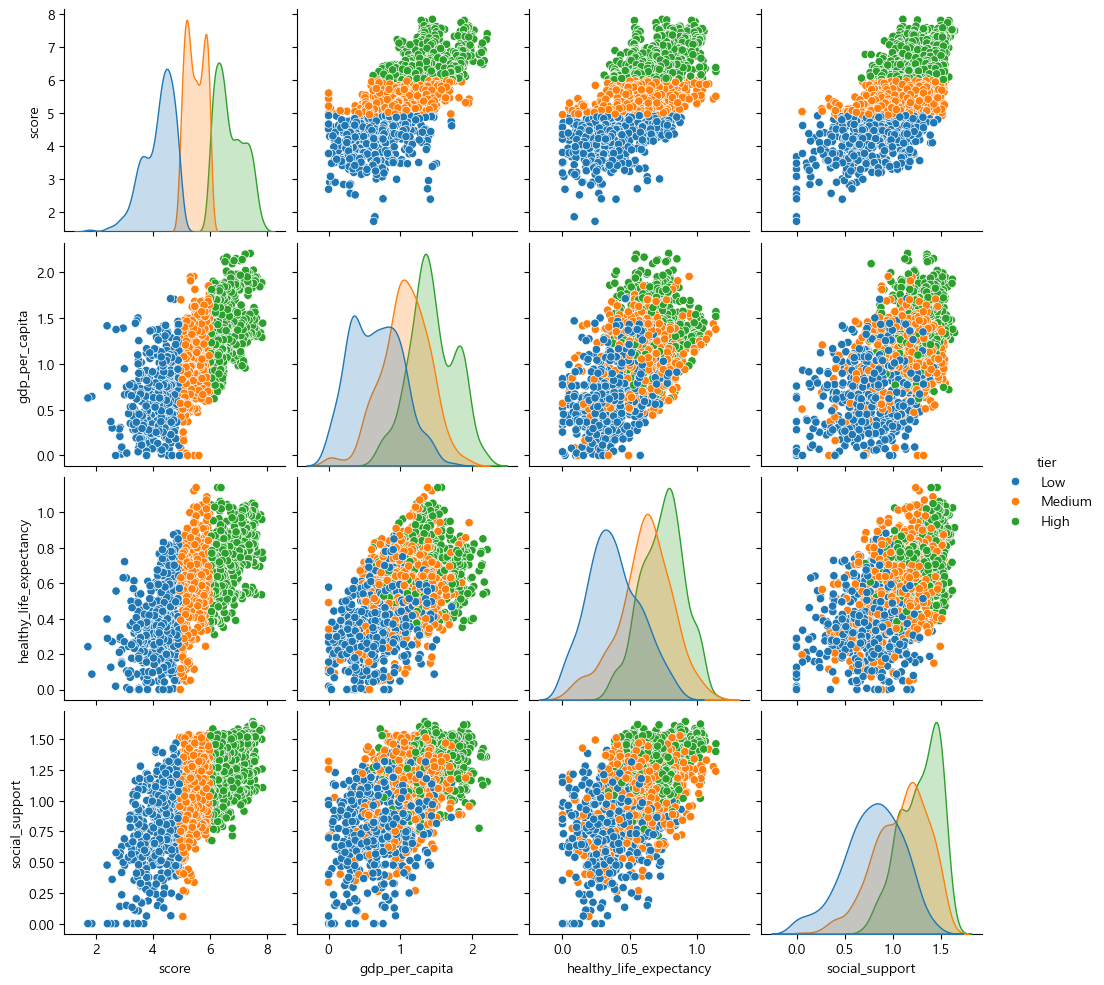

In [106]:
if 'tier' not in happiness_df.columns:
    happiness_df['tier'] = pd.qcut(happiness_df['score'], q=3, labels=['Low', 'Medium', 'High'])

sns.pairplot(happiness_df[['score', 'gdp_per_capita', 'healthy_life_expectancy', 'social_support', 'tier']], hue='tier')
plt.show()

In [107]:
corr_mat = happiness_df.corr(numeric_only=True)
display(corr_mat)

,year,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption
year,1.000000,-0.066859,0.061730,0.377960,0.056867,-0.164926,0.378851,-0.308979,0.058155
rank,-0.066859,1.000000,-0.985148,-0.728970,-0.658790,-0.678641,-0.545133,-0.060866,-0.403866
score,0.061730,-0.985148,1.000000,0.713724,0.663865,0.679125,0.557326,0.081295,0.419513
gdp_per_capita,0.377960,-0.728970,0.713724,1.000000,0.542003,0.545342,0.473856,-0.172166,0.350871
social_support,0.056867,-0.658790,0.663865,0.542003,1.000000,0.558423,0.381393,-0.011240,0.161394
healthy_life_expectancy,-0.164926,-0.678641,0.679125,0.545342,0.558423,1.000000,0.232928,0.035189,0.258586
freedom,0.378851,-0.545133,0.557326,0.473856,0.381393,0.232928,1.000000,0.112511,0.420912
generosity,-0.308979,-0.060866,0.081295,-0.172166,-0.011240,0.035189,0.112511,1.000000,0.209426
corruption,0.058155,-0.403866,0.419513,0.350871,0.161394,0.258586,0.420912,0.209426,1.000000


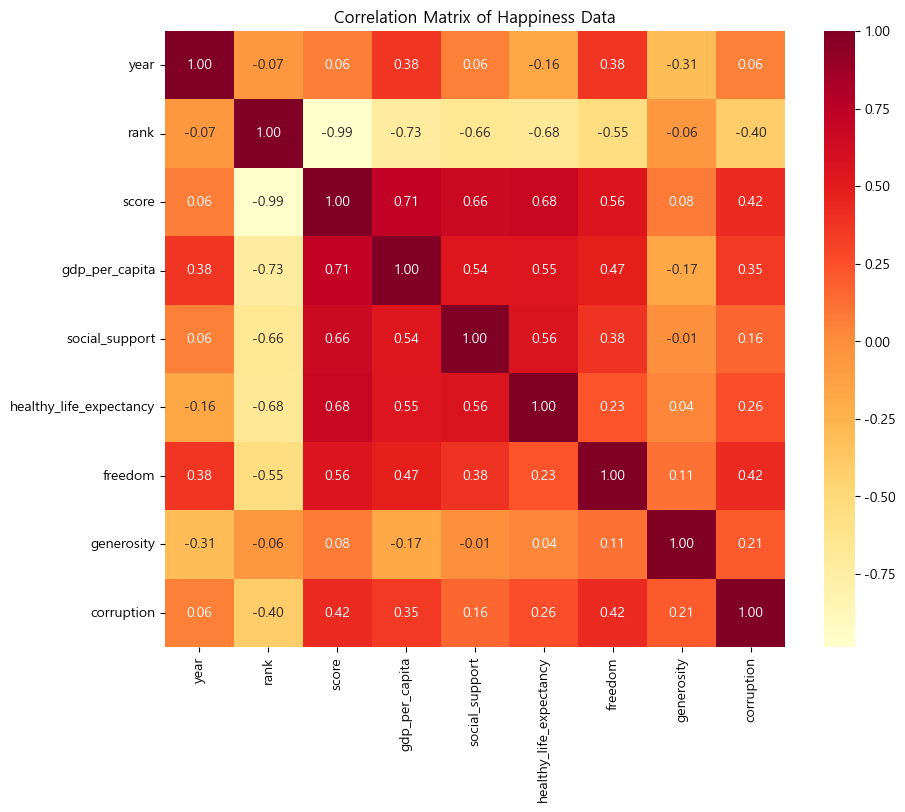

In [108]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat, annot=True, cmap="YlOrRd", fmt='.2f')
plt.title('Correlation Matrix of Happiness Data')
plt.show()

In [109]:
cross_tab = pd.crosstab(happiness_df['tier'], happiness_df['year'])
display(cross_tab)

year,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
tier,,,,,,,,,,
Low,62,57,55,56,57,51,44,39,39,44
Medium,53,53,56,54,47,50,53,51,43,43
High,43,47,44,46,52,52,52,56,55,56


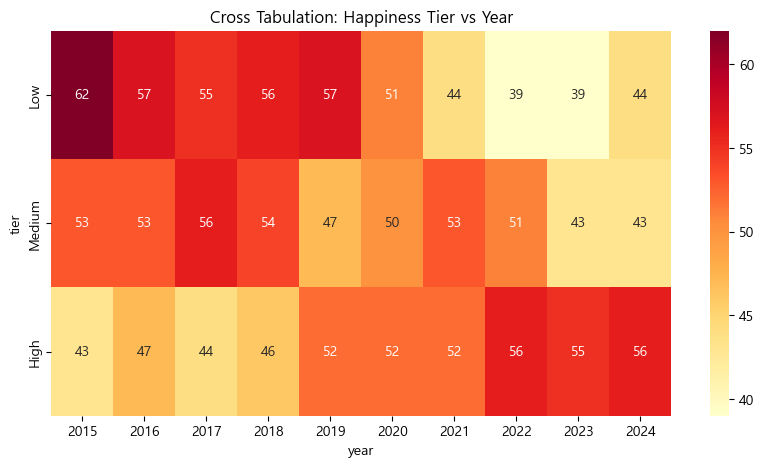

In [110]:
plt.figure(figsize=(10, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Cross Tabulation: Happiness Tier vs Year')
plt.show()

In [111]:
numeric_cols = [
    "gdp_per_capita",
    "social_support",
    "healthy_life_expectancy",
    "freedom",
    "generosity",
    "corruption",
]

In [112]:
for col in numeric_cols:
    if happiness_df[col].isnull().sum() > 0:
        happiness_df[col] = happiness_df[col].fillna(happiness_df[col].median())

print(happiness_df.isna().sum())

year                       0
country                    0
rank                       0
score                      0
gdp_per_capita             0
social_support             0
healthy_life_expectancy    0
freedom                    0
generosity                 0
corruption                 0
tier                       0
dtype: int64


In [113]:
from sklearn.preprocessing import LabelEncoder

# 1. 범주형 데이터 수치형 변경 (Label Encoding)
# 국가 이름(Country)을 숫자로 변환
encoder = LabelEncoder()
happiness_df = happiness_df.assign(Country_Encoded=encoder.fit_transform(happiness_df['country']))

# 어떤 위치 숫자로 바꿨는지 상위 10개만 확인
print("인코딩된 클래스(상위 10개):", encoder.classes_[:10])

인코딩된 클래스(상위 10개): ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Azerbaijan*']


In [114]:
# 2. 파생변수 (행복 등급을 숫자로 변경하여 상관계수 분석에 포함)
happiness_df = happiness_df.assign(tier_num=pd.qcut(happiness_df['score'], q=3, labels=[0, 1, 2]))
happiness_df['tier_num'] = happiness_df['tier_num'].astype(int)

Text(0.5, 1.0, 'Original Generosity')

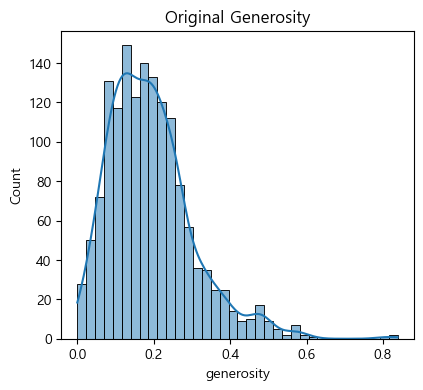

In [115]:
# 3. 로그 변환 (편향 개선)
# 이상치가 많거나 0으로 치우쳐 있는 Generosity(관대함) 또는 Corruption 지표를 로그 변환
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=happiness_df, x='generosity', kde=True)
plt.title('Original Generosity')

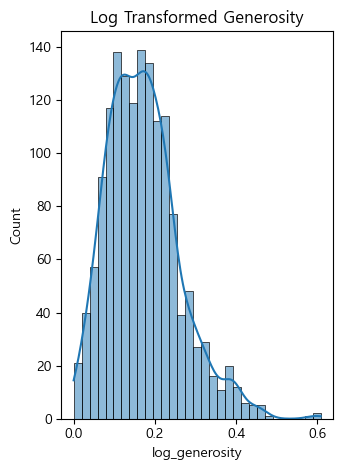

In [116]:
happiness_df.loc[:, 'log_generosity'] = happiness_df['generosity'].apply(lambda x: np.log1p(x))

plt.subplot(1, 2, 2)
sns.histplot(data=happiness_df, x='log_generosity', kde=True)
plt.title('Log Transformed Generosity')
plt.tight_layout()
plt.show()

In [117]:
happiness_df.head()

,year,country,rank,score,gdp_per_capita,social_support,healthy_life_expectancy,freedom,generosity,corruption,tier,Country_Encoded,tier_num,log_generosity
0,2015,Switzerland,1,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,High,170,2,0.259884
1,2015,Iceland,2,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,High,73,2,0.362070
2,2015,Denmark,3,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,High,45,2,0.293706
3,2015,Norway,4,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,High,133,2,0.297872
4,2015,Canada,5,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,High,28,2,0.377141


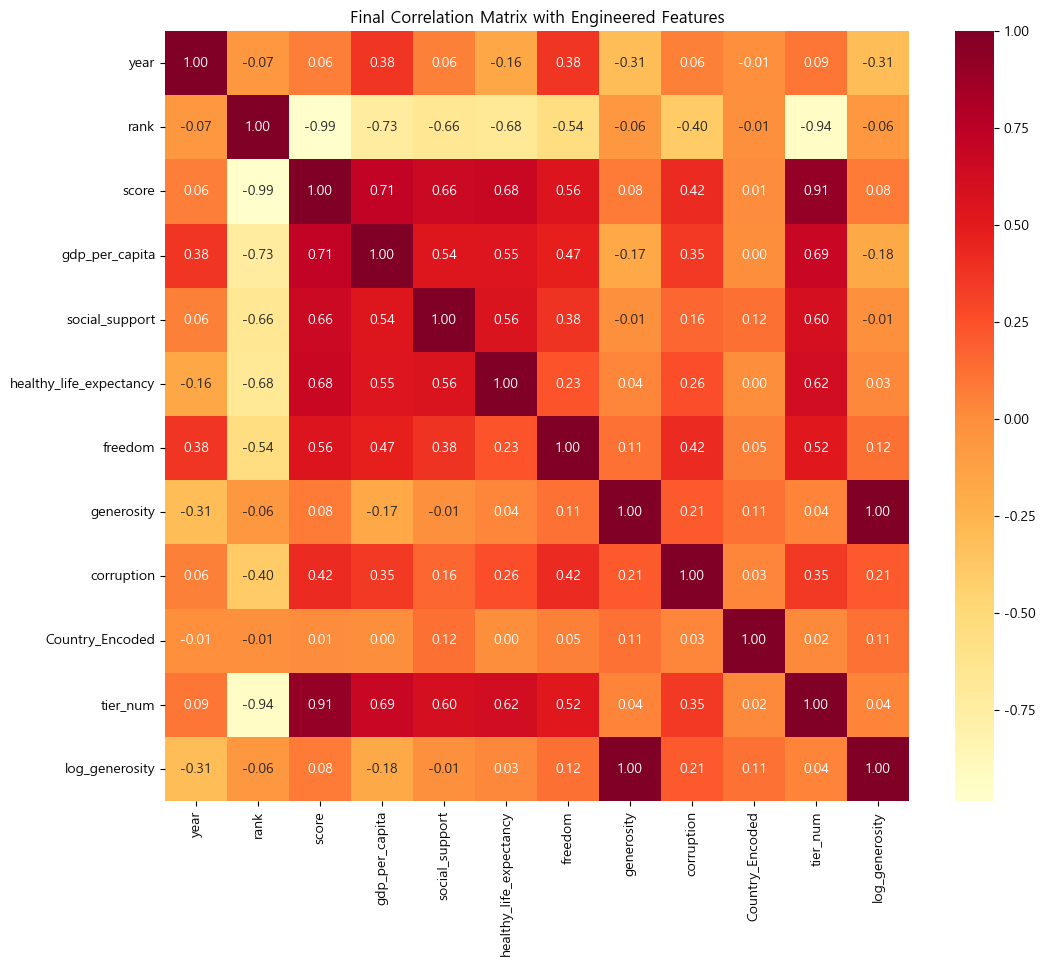

In [118]:
corr_mat_final = happiness_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_mat_final, annot=True, cmap="YlOrRd", fmt='.2f')
plt.title('Final Correlation Matrix with Engineered Features')
plt.show()